# **Humour Detection**

**Dataset Description**

The following dataset was proposed by Annamoradnejad et al. in Dec. 2022. [1]. This dataset was created only for humour detection task. You can use the following dataset available in Kaggle: https://www.kaggle.com/datasets/deepcontractor/200k-short-texts-for-humor-detection

The authors justify the creation of this dataset by pointing out that pre-existing datasets for humour detection binary task were not large and rich enough to allow for robust and generalisable training and performances.  The dataset was created from two different data sources, one with humour texts and one without. The first set of texts comes from the News Category Dataset, published under CC0 Public Domain, containing various textual information (categories, stories, urls etc.) from the Huffington Post from 2012 to 2018. These texts belong to different categories such as politics, welfare, economics and entertainment. The second group of texts comes from the Jokes dataset, collected from the Reddit2 community and containing jokes/humour short texts. 

Several pre-processing and filtering steps were applied on the following dataset. 
Some of the steps are: 
- Removal of duplicate texts
- Selection of pairs of texts (one from each group) with similar statistics, so as to have comparable and similar statistical destructions between the two groups. 
- Maintaining texts with a character length between 30 and 100 and a word length between 10 and 18. 
- Sentence Case formatting keeping the first character of the sentences in capital and lower-casing the rest.
The final dataset contains 200k labelled short texts distributed equally between humour and non-humour. 

The application of other preprocessing techniques is left to the reader


**Task**

The objective of this assigment is to use a pre-trained BERT-based model that correctly classifies texts between humour and non-humour class.




**Model Architecture**

I will train a pre-trained **DistilBERT** from Huggingface 🤗 `transformers` library. You can find documentation at the following link: https://huggingface.co/distilbert-base-uncased. DistilBERT was introduce in paper DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter by Sanh et al. [2] from Hugging Face. 

In recent years, transfer learning models has been widely used for basic NLP tasks. Although they performs remarkably well, the models are remarkably complex and requires high computational resources for training and inference. One of the main challenges is to find a way to reduce the size of these large models without affecting the performance. DistilBERT has been created to solve this problem. As the name suggests, DistilBERT is based on the principle of **knowledge distillation**: a large complex model (*teacher*) distils its knowledge and passes it to train a smaller network (*student*) to match the output. DistilBERT is a smaller, faster, cheaper and lighter transformer compared to BERT-based transformers. It has 40% less parameters, it runs 60% faster preserving 95% of BERT's performances.

**Setup**

The notebook is divided into two parts. In the first I train DistilBERT on the original data, while in the second I train DistilBERT on the original dataset on which I have applied a basic text preprocessing pipeline. I use `DistilBertTokenizerFast` as tokenizer and `DistilBertForSequenceClassification` as model from HuggingFace. I evaluate my performances calculating Accuracy and F1 Score. 


**How to Run the Code**

Unless otherwise specified in the notebook section all codes can be runned in Google Colaboratory platform. All notebooks all already setted to import the necessary packages and also in this way you can easily use a GPU!

## 1. **Environment Setup**

In [ ]:
# pip install transformers

In [ ]:
# pip install evaluate

In [ ]:
# pip install --user -U nltk

In [ ]:
# pip install contractions

In [ ]:
# pip install unidecode

In [6]:
# nvidia gpu information
!nvidia-smi

Thu Apr 13 09:52:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    41W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
# Import useful libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import IPython.display as ipd # Notebook only
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# Additional Pre-processing
import re
import unidecode
import contractions
import nltk
from nltk.corpus import stopwords

# Classification
import torch
from torch.utils.data import  Dataset
from transformers import (
    DistilBertConfig, 
    DistilBertTokenizerFast, 
    DistilBertForSequenceClassification, 
    DistilBertTokenizer, 
    TrainingArguments, 
    Trainer)
from evaluate import load

# File management
from google.colab import drive
import tarfile
from shutil import copyfile

In [7]:
# Declaration of which device to use during training and inference for torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
# Mount GDrive
drive.mount('/content/gdrive/', force_remount = True) 

Mounted at /content/gdrive/


## 2. **Dataset**

I download the CSV and I import it with `pandas` library. <br>
I convert True/False labels of *humor* into a 0/1.

In [9]:
# Import
df = pd.read_csv("/content/gdrive/MyDrive/RH Assigment/dataset.csv")
df["label"] = df["humor"].astype(int) 

df

,text,humor,label
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False,0
1,Watch: darvish gave hitter whiplash with slow ...,False,0
2,What do you call a turtle without its shell? d...,True,1
3,5 reasons the 2016 election feels so personal,False,0
4,"Pasco police shot mexican migrant from behind,...",False,0
...,...,...,...
199995,Conor maynard seamlessly fits old-school r&b h...,False,0
199996,How to you make holy water? you boil the hell ...,True,1
199997,How many optometrists does it take to screw in...,True,1
199998,Mcdonald's will officially kick off all-day br...,False,0


I create a sampled dataset maintaining the initial prior probabilities for each class: 50% funny texts, 50% neutral texts. 

In [61]:
df_reduced = df.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=0.6))
df.to_csv('/content/gdrive/MyDrive/RH Assigment/dataset_reduced.csv', index=False)

df_reduced

,text,humor,label
151382,Six quirky reasons to fall in love with portland,False,0
160200,Hillary clinton's super pac has raised more mo...,False,0
39931,Study: us cities have worse inequality than me...,False,0
153307,Rza loves...clarks wallabies? (and more findin...,False,0
185999,Trevor noah highlights an awful consequence of...,False,0
...,...,...,...
5533,Insanity is defined as doing the same thing ov...,True,1
125738,Why is today a trucker's favorite day? cuz it'...,True,1
134525,So my friend held up a can of coke... and aske...,True,1
74069,There are 10 types of people in the world. tho...,True,1


### 2.1 Exploratory Analysis

In [ ]:
print(f'df type is: {type(df)}')
print(f'df shape is: {df.shape}')

df type is: <class 'pandas.core.frame.DataFrame'>
df shape is: (200000, 3)


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    200000 non-null  object
 1   humor   200000 non-null  bool  
 2   label   200000 non-null  int64 
dtypes: bool(1), int64(1), object(1)
memory usage: 3.2+ MB
None


In [ ]:
df["humor"].value_counts(normalize=True)

False    0.5
True     0.5
Name: humor, dtype: float64

In [ ]:
df_reduced["humor"].value_counts(normalize=True)

False    0.5
True     0.5
Name: humor, dtype: float64

## 3. **Experimental Setup V1**

### 3.1 Split Data into Training, Validation and Test

I use `numpy` library to split the data into training, validation, and test sets.

In [11]:
# 80% training, 10% validation, 10% test
train, val, test = np.split(df.sample(frac=1, random_state=42), 
                       [int(.9*len(df)), int(.95*len(df))])

In [12]:
# 180000 texts training, 10000 texts validation, 10000 texts test
print(train.shape, val.shape, test.shape)

(180000, 3) (10000, 3) (10000, 3)


In [13]:
# Prior probabilities for each class are maintained
print(train["humor"].value_counts(normalize=True))
print(val["humor"].value_counts(normalize=True))
print(test["humor"].value_counts(normalize=True))

True     0.500167
False    0.499833
Name: humor, dtype: float64
False    0.504
True     0.496
Name: humor, dtype: float64
True     0.501
False    0.499
Name: humor, dtype: float64


### 3.2 Tokenization

Tokenization is a necessary step to fine-tune and train a NLP model, in this case pre-trained DistilBERT. Tokenization consists into converting each text into a vector of integers, each word, groups of words, or symbol into a number according to the vocabulary tokenizer. I will use `DistilBertTokenizerFast` from HuggingFace’s `tokenizers` library. The word vocabulary size is 30522, padding the vector is to the right, the maximum length (in number of tokens) for the inputs to the transformer model is 512, there is a list of some special tokens, including the separator token SEP and the pad token PAD.

In [12]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
tokenizer

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

To keep the dataset consistent and able to be trained, I decide to pad the token vectors to a fixed length equal to 50. 

In [13]:
train_encodings = tokenizer(list(train['text']), padding='max_length', truncation=True, max_length=50) 
val_encodings = tokenizer(list(val['text']), padding='max_length', truncation=True, max_length=50)
test_encodings = tokenizer(list(test['text']), padding='max_length', truncation=True, max_length=50)

Each data has two keys: `input_ids` and `attention_mask`: 

- `input_ids` are indices, numerical representatios of tokens building the sequences that will be used as input by the model.
- `attention_mask` are indices 0, 1 that indicate to the model which tokens should be attended to, and which should not.

In [ ]:
train_encodings.keys()

dict_keys(['input_ids', 'attention_mask'])

Histogram of the length of characters in the text samples included in the training set. The variable *length of characters* follows approximately Normal Distrbution.

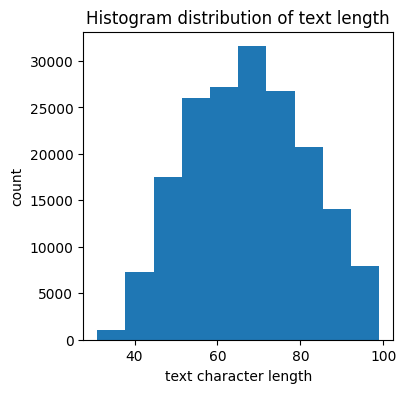

In [16]:
text_len = [len(x) for x in list(train['text'])]

fig, ax = plt.subplots(figsize=(4, 4))
plt.hist(text_len)
plt.xlabel("text character length")
plt.ylabel("count")
plt.title("Histogram distribution of text length")
plt.show()

To observe which tokens are the most recurrent in the texts included in the dataset, I produce a word cloud. <br>
First, I plot a word cloud for *non-humorous* texts. 

In [ ]:
#for non-humorous
all_nonhumorous_words = ''
for idx,text_data in enumerate(list(train['text'])):
    if list(train['label'])[idx] == 0:
        all_nonhumorous_words += ' ' + text_data.strip() 
    
        
wc = WordCloud(width=1024,height=1024, min_font_size=8, stopwords=STOPWORDS).generate(all_nonhumorous_words)

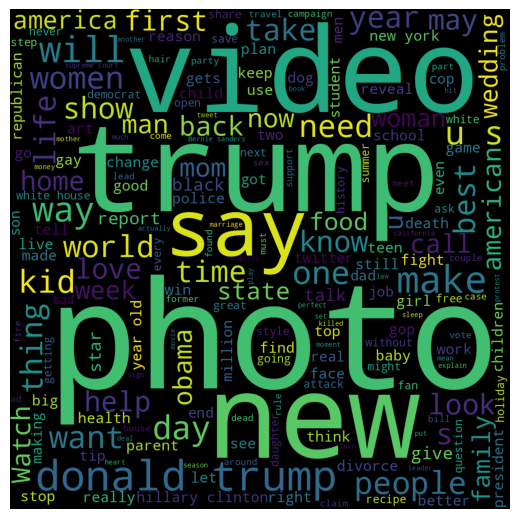

In [ ]:
plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wc)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

I plot a word cloud for *humorous* texts

In [ ]:
#for humorous
all_humorous_words = ''
for idx,text_data in enumerate(list(train['text'])):
    if list(train['label'])[idx] == 1:
        all_humorous_words += ' ' + text_data.strip() 
        
wc2 = WordCloud(width=1024,height=1024, min_font_size=8, stopwords=STOPWORDS).generate(all_humorous_words)

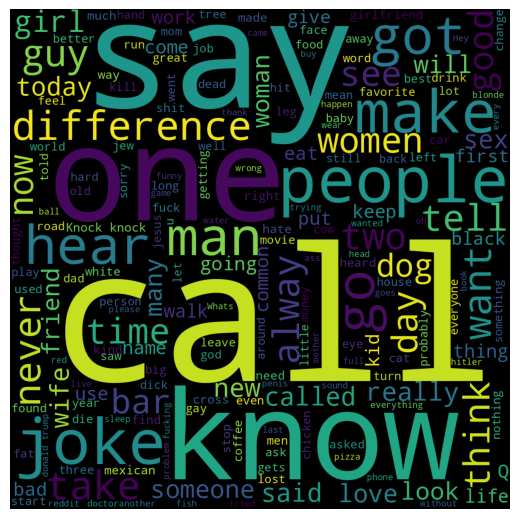

In [ ]:
plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wc2)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

### 3.3 Dataset

I create a `PyTorch Dataset` class to allow model to train. <br>
**HumorDetectionDataset** takes in input *encodings* previously created with toeknizer and *labels* associated with each vector of tokens. It returns a dictionary in which the keys are *input_ids*, *attention_mask* and label and the values their corresponding elements.

In [14]:
class HumorDetectionDataset(Dataset):

    def __init__(self, encodings, labels):

        self.encodings = encodings # input
        self.labels = labels # label
  
    def __getitem__(self, idx):
      
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
  
    def __len__(self):
        return len(self.labels)

In [15]:
# Dataset
train_dataset = HumorDetectionDataset(train_encodings, list(train['label']))
val_dataset = HumorDetectionDataset(val_encodings, list(val['label']))
test_dataset = HumorDetectionDataset(test_encodings, list(test['label']))

Now, I print some information for a sample sentence from *test_dataset*.

In [19]:
index = torch.LongTensor(test_dataset[0]['input_ids']).to(device).unsqueeze(0)
attn_mask =  torch.LongTensor(test_dataset[0]['attention_mask']).to(device).unsqueeze(0)

print(f"Original sentence = {list(test['text'])[0]}") # sample sentence
print(f"Original label = {list(test['label'])[0]}.") # label 
print(f"Original humor = {list(test['humor'])[0]}.") # humor class
print(f'index={index}') # input_ids: token vector 
print(f'attn_mask={attn_mask}') # attention_mask

Original sentence = My ex-girlfriend was an astronaut. so i guess you could say that, i've had a spacex.
Original label = 1.
Original humor = True.
index=tensor([[  101,  2026,  4654,  1011,  6513,  2001,  2019, 19748,  1012,  2061,
          1045,  3984,  2017,  2071,  2360,  2008,  1010,  1045,  1005,  2310,
          2018,  1037,  2686,  2595,  1012,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]],
       device='cuda:0')
attn_mask=tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]], device='cuda:0')


With the tokenizer, I decode the data from the vector of integers back to the text. 

In [16]:
decoded = tokenizer.decode(test_dataset[0]['input_ids']) 
decoded

"[CLS] my ex - girlfriend was an astronaut. so i guess you could say that, i've had a spacex. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]"

### 3.4 Training 

Before starting the training is necessary to define training arguments. I use `TrainingArguments` function from Huggingface. <br>
Main arguments are: 
- num_train_epochs: 10 (since I fine-tune a pre-trained model it's not necessary to train it for high number of epochs)
- batch size: 256
- evaluation_strategy: "epoch" (evaluation is done at the end of each epoch)
- logging_steps: 50 (50 update steps between two logs)
- save_strategy: "epoch" (checkpoint are saved at the end of each epoch)

**Optimizer** and **loss function** are set authomatically from HuggingFace and they refer to DistilBERT. <br> 
The optimizer is AdamW and the loss function is a linear combination of distill loss (Lce), Masked language modelling loss (Lmlm) and Cosine embedding loss (Lcos). 

In [20]:
training_args = TrainingArguments(
    output_dir="./output_results",
    num_train_epochs=10,
    per_device_train_batch_size=256,
    per_device_eval_batch_size=256,
    evaluation_strategy="epoch", 
    save_strategy="epoch",
    logging_steps=50,
    report_to="none"
)

I load accuracy and F1 score metrics of `evaluate` package from HuggingFace. These metrics are used to evaluate the classification performances. 

In [21]:
metric1 = load("accuracy")
metric2 = load("f1")
# see perplexity
def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        accuracy = metric1.compute(predictions=predictions, references=labels)
        f1 = metric2.compute(predictions=predictions, references=labels)
        return {"accuracy": accuracy, "f1": f1}

In [ ]:
# Distilbert architecture characteristics
DistilBertConfig()

DistilBertConfig {
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "transformers_version": "4.27.4",
  "vocab_size": 30522
}

I load pre-trained DistilBERT model with `DistilBertForSequenceClassification` from HuggingFace and I place it to the available device. 

In [22]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")
model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

I define the `Trainer` function. "Trainer is a simple but feature-complete training and eval loop for PyTorch, optimized for 🤗 Transformers". I pass model, training arguments, train dataset, validation dataset and compute metrics function to the Trainer. 

In [23]:
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,             # evaluation dataset
    compute_metrics=compute_metrics
    )

Finally, I perform the training and I save the model in *model_1* variable. 

In [24]:
# Training
trainer.train()
trainer.save_model('/content/gdrive/MyDrive/RH Assigment/model_1')

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.044400,0.043781,{'accuracy': 0.9854},{'f1': 0.9853177795655671}
2,0.021400,0.041988,{'accuracy': 0.9878},{'f1': 0.9877090469474109}
3,0.007600,0.054693,{'accuracy': 0.9862},{'f1': 0.9860830980233966}
4,0.005000,0.060557,{'accuracy': 0.9878},{'f1': 0.9876966518757564}
5,0.003200,0.073418,{'accuracy': 0.9874},{'f1': 0.9872443814537356}
6,0.002000,0.078279,{'accuracy': 0.9869},{'f1': 0.9868275515334338}
7,0.000500,0.082711,{'accuracy': 0.9869},{'f1': 0.9867850297589025}
8,0.000300,0.090525,{'accuracy': 0.9874},{'f1': 0.9872830036334275}
9,0.000200,0.095746,{'accuracy': 0.9878},{'f1': 0.9876842317787199}
10,0.000100,0.097002,{'accuracy': 0.9878},{'f1': 0.9876941698608028}


In [25]:
trainer.evaluate()

{'eval_loss': 0.0970020666718483,
 'eval_accuracy': {'accuracy': 0.9878},
 'eval_f1': {'f1': 0.9876941698608028},
 'eval_runtime': 3.4559,
 'eval_samples_per_second': 2893.617,
 'eval_steps_per_second': 11.574,
 'epoch': 10.0}

From the results of the metrics, I can see that the model succeeds almost perfectly in classifying texts as humour and non-humour. After only 10 epochs and 30 minutes, the model achieves almost 100% accuracy and F1 score. 

### 3.5 Inference

After saving the previously trained model, it is now possible to make inference on new data never seen by the model. At this stage we use the test set.

In [26]:
output_model_folder = '/content/gdrive/MyDrive/RH Assigment/model_1' #this may change depending on where you saved your model.
model_inference = DistilBertForSequenceClassification.from_pretrained(output_model_folder) 
model_inference.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [27]:
trainer = Trainer(
    model=model_inference,               # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset,           # evaluation dataset
    compute_metrics=compute_metrics
    )

In [28]:
# equal to trainer.predict(test_dataset=test_dataset).metrics
metrics = trainer.evaluate()
metrics

{'eval_loss': 0.08820956200361252,
 'eval_accuracy': {'accuracy': 0.9886},
 'eval_f1': {'f1': 0.9886000000000001},
 'eval_runtime': 3.4546,
 'eval_samples_per_second': 2894.732,
 'eval_steps_per_second': 11.579}

In [ ]:
type(metrics)

dict

In [ ]:
for key in metrics:
  key_pt1 = key.split('_')[0]
  key_pt2 = key.split('_')[1]
  if key_pt2 == 'accuracy' or key_pt2 == 'f1':
    metrics[key] = metrics[key][key_pt2]
# metrics

In [30]:
metrics["eval_samples"] = len(test_dataset)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  eval_accuracy           =     0.9886
  eval_f1                 =     0.9886
  eval_loss               =     0.0882
  eval_runtime            = 0:00:03.45
  eval_samples            =      10000
  eval_samples_per_second =   2894.732
  eval_steps_per_second   =     11.579


The following results show how the DistilBERT model pre-trained on the original dataset manages to generalise perfectly on new data, achieving an accuracy and F1 score value of 99%.

## 4. **Experimental Setup V2**

The results previously obtained are satisfactory, only out of curiosity I decide to apply the model again on texts on which I apply a basic text preprocessing pipeline. 

Some of them are: 
- Conversion to lower case
- Contractions expansion
- Accent Removal
- Stopwords removal 

Other more complex text preprocessing techniques can be applied, such as: spelling correction, stemming, lemmatization etc. I will not go throught that in this notebook. 

Next, I apply the same steps I presented in the previous version.

### 4.1 Preprocessing

In [17]:
text = list(df['text'])
text[:10]

["Joe biden rules out 2020 bid: 'guys, i'm not running'",
 'Watch: darvish gave hitter whiplash with slow pitch',
 'What do you call a turtle without its shell? dead.',
 '5 reasons the 2016 election feels so personal',
 'Pasco police shot mexican migrant from behind, new autopsy shows',
 'Martha stewart tweets hideous food photo, twitter responds accordingly',
 "What is a pokemon master's favorite kind of pasta? wartortellini!",
 'Why do native americans hate it when it rains in april? because it brings mayflowers.',
 "Obama's climate change legacy is impressive, imperfect and vulnerable",
 "My family tree is a cactus, we're all pricks."]

In [18]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [19]:
def pipeline_preprocess(text:list=[]) -> list : 

  # to lowercase
  text = [phrase.lower() for phrase in text]

  # Expanding contractions
  text = [contractions.fix(phrase) for phrase in text]

  # punctuation removal 
  text = [re.sub(r'[^\w\s]', '', phrase) for phrase in text]

  # accent removal
  text = [unidecode.unidecode(phrase) for phrase in text]

  # stopwords removal
  def remove_stopwords(text):
    text_new=[]
    stopwords_list = stopwords.words('english')
    for phrase in text:
      string = ""
      for word in phrase.split(" "):
        if word.strip() in stopwords_list:
          continue
        else:
          string = string + " " + word
      text_new.append(string.strip())
    return text_new
  
  text = remove_stopwords(text)

  text = [phrase.strip() for phrase in text]

  return text

In [20]:
text = pipeline_preprocess(text)

In [21]:
text[:10]

['joe biden rules 2020 bid guys running',
 'watch darvish gave hitter whiplash slow pitch',
 'call turtle without dead',
 '5 reasons 2016 election feels personal',
 'pasco police shot mexican migrant behind new autopsy shows',
 'martha stewart tweets hideous food photo twitter responds accordingly',
 'pokemon masters favorite kind pasta wartortellini',
 'native americans hate rains april brings mayflowers',
 'obamas climate change legacy impressive imperfect vulnerable',
 'family tree cactus pricks']

In [22]:
df.head(8)

,text,humor,label
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False,0
1,Watch: darvish gave hitter whiplash with slow ...,False,0
2,What do you call a turtle without its shell? d...,True,1
3,5 reasons the 2016 election feels so personal,False,0
4,"Pasco police shot mexican migrant from behind,...",False,0
5,"Martha stewart tweets hideous food photo, twit...",False,0
6,What is a pokemon master's favorite kind of pa...,True,1
7,Why do native americans hate it when it rains ...,True,1


In [23]:
df['text'] = text

In [24]:
df.head(8)

,text,humor,label
0,joe biden rules 2020 bid guys running,False,0
1,watch darvish gave hitter whiplash slow pitch,False,0
2,call turtle without dead,True,1
3,5 reasons 2016 election feels personal,False,0
4,pasco police shot mexican migrant behind new a...,False,0
5,martha stewart tweets hideous food photo twitt...,False,0
6,pokemon masters favorite kind pasta wartortellini,True,1
7,native americans hate rains april brings mayfl...,True,1


### 4.2 Split Data into Training, Validation and Test

In [26]:
train, val, test = np.split(df.sample(frac=1, random_state=42), 
                       [int(.9*len(df)), int(.95*len(df))])

In [27]:
print(train.shape, val.shape, test.shape)

(180000, 3) (10000, 3) (10000, 3)


In [33]:
print(train["humor"].value_counts(normalize=True))
print(val["humor"].value_counts(normalize=True))
print(test["humor"].value_counts(normalize=True))

True     0.501519
False    0.498481
Name: humor, dtype: float64
False    0.519
True     0.481
Name: humor, dtype: float64
False    0.508333
True     0.491667
Name: humor, dtype: float64


### 4.3 Tokenzation

In [28]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
tokenizer

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [29]:
train_encodings = tokenizer(list(train['text']), padding='max_length', truncation=True, max_length=50) 
val_encodings = tokenizer(list(val['text']), padding='max_length', truncation=True, max_length=50)
test_encodings = tokenizer(list(test['text']), padding='max_length', truncation=True, max_length=50)

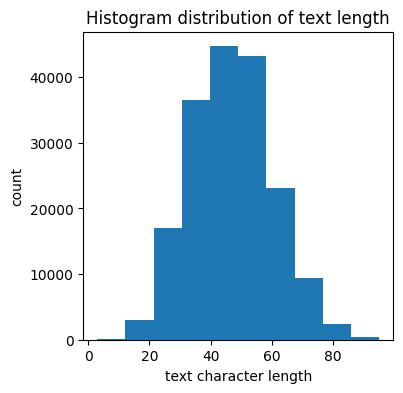

In [31]:
text_len = [len(x) for x in list(train['text'])]

fig, ax = plt.subplots(figsize=(4, 4))
plt.hist(text_len)
plt.xlabel("text character length")
plt.ylabel("count")
plt.title("Histogram distribution of text length")
plt.show()

In [32]:
#for non-humorous

all_nonhumorous_words = ''
for idx,text_data in enumerate(list(train['text'])):
    if list(train['label'])[idx] == 0:
        all_nonhumorous_words += ' ' + text_data.strip() 
    
        
wc = WordCloud(width=1024,height=1024, min_font_size=8, stopwords=STOPWORDS).generate(all_nonhumorous_words)

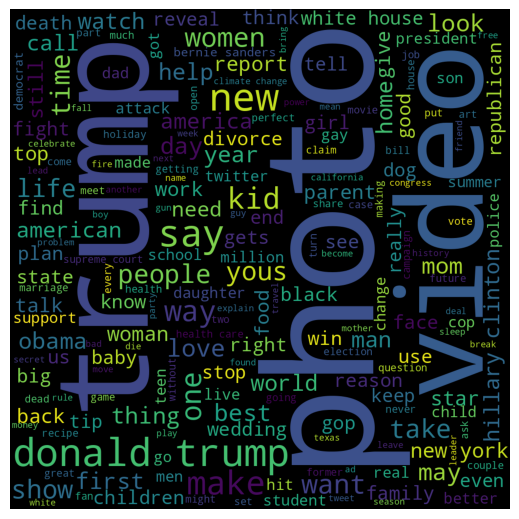

In [33]:
#Plotting the wordcloud for nonhumorous
plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wc)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [34]:
#for humorous

all_humorous_words = ''
for idx,text_data in enumerate(list(train['text'])):
    if list(train['label'])[idx] == 1:
        all_humorous_words += ' ' + text_data.strip() 
        
wc2 = WordCloud(width=1024,height=1024, min_font_size=8, stopwords=STOPWORDS).generate(all_humorous_words)

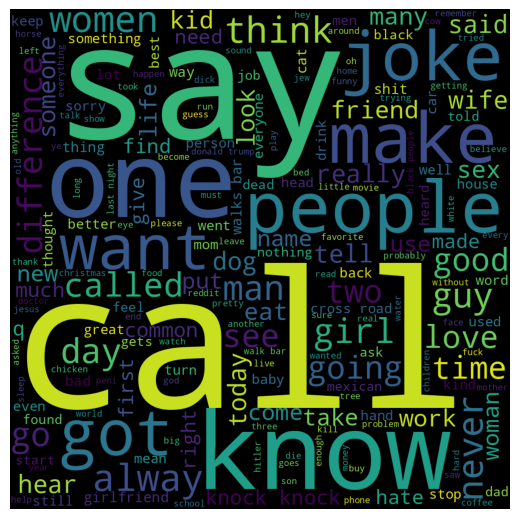

In [35]:
plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wc2)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

### 4.4 Dataset

In [36]:
class HumorDetectionDataset(Dataset):

    def __init__(self, encodings, labels):

        self.encodings = encodings # input
        self.labels = labels # label
  
    def __getitem__(self, idx):
      
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
  
    def __len__(self):
        return len(self.labels)

In [37]:
# Dataset
train_dataset = HumorDetectionDataset(train_encodings, list(train['label']))
val_dataset = HumorDetectionDataset(val_encodings, list(val['label']))
test_dataset = HumorDetectionDataset(test_encodings, list(test['label']))

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

index = torch.LongTensor(test_dataset[0]['input_ids']).to(device).unsqueeze(0)
attn_mask =  torch.LongTensor(test_dataset[0]['attention_mask']).to(device).unsqueeze(0)
print(f"Original sentence = {list(test['text'])[0]}")
print(f"Original label = {list(test['label'])[0]}.")
print(f"Original humor = {list(test['humor'])[0]}.")
print(f'index={index}')
print(f'attn_mask={attn_mask}')

Original sentence = exgirlfriend astronaut guess could say spacex
Original label = 1.
Original humor = True.
index=tensor([[  101,  4654, 15239, 19699,  9013,  2094, 19748,  3984,  2071,  2360,
          2686,  2595,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]],
       device='cuda:0')
attn_mask=tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]], device='cuda:0')


### 4.5 Training 

In [39]:
training_args = TrainingArguments(
    output_dir="./output_results",
    num_train_epochs=10,
    per_device_train_batch_size=256,
    per_device_eval_batch_size=256,
    evaluation_strategy="epoch", 
    save_strategy="epoch",
    logging_steps=50,
    report_to="none"
)

In [40]:
metric1 = load("accuracy")
metric2 = load("f1")
# see perplexity
def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        accuracy = metric1.compute(predictions=predictions, references=labels)
        f1 = metric2.compute(predictions=predictions, references=labels)
        return {"accuracy": accuracy, "f1": f1}

In [48]:
DistilBertConfig()

DistilBertConfig {
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "transformers_version": "4.27.4",
  "vocab_size": 30522
}

In [41]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")
model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_clas

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [42]:
trainer = Trainer(
    model=model,                         
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=val_dataset,            
    compute_metrics=compute_metrics
    )

In [43]:
# Training
trainer.train()
trainer.save_model('/content/gdrive/MyDrive/RH Assigment/model_2')

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.163100,0.164256,{'accuracy': 0.9329},{'f1': 0.9298630709731368}
2,0.106100,0.147394,{'accuracy': 0.9469},{'f1': 0.9462604999493979}
3,0.054500,0.190844,{'accuracy': 0.9437},{'f1': 0.9422386375294963}
4,0.028100,0.227668,{'accuracy': 0.9455},{'f1': 0.9447765731077111}
5,0.014900,0.246267,{'accuracy': 0.9462},{'f1': 0.9451915240423798}
6,0.012800,0.264192,{'accuracy': 0.9468},{'f1': 0.9458909682668837}
7,0.009200,0.285587,{'accuracy': 0.9475},{'f1': 0.9465648854961831}
8,0.005300,0.315313,{'accuracy': 0.9485},{'f1': 0.9479324638560307}
9,0.002600,0.333925,{'accuracy': 0.9477},{'f1': 0.9472729105756628}
10,0.003200,0.346832,{'accuracy': 0.9478},{'f1': 0.9471124620060791}


In [44]:
trainer.evaluate()

{'eval_loss': 0.3468318283557892,
 'eval_accuracy': {'accuracy': 0.9478},
 'eval_f1': {'f1': 0.9471124620060791},
 'eval_runtime': 3.4852,
 'eval_samples_per_second': 2869.309,
 'eval_steps_per_second': 11.477,
 'epoch': 10.0}

### 4.6 Inference

In [45]:
output_model_folder = '/content/gdrive/MyDrive/RH Assigment/model_2'
model_inference = DistilBertForSequenceClassification.from_pretrained(output_model_folder) 
model_inference.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [46]:
trainer = Trainer(
    model=model_inference,               
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=test_dataset,          
    compute_metrics=compute_metrics
    )

In [47]:
metrics = trainer.evaluate()
metrics

{'eval_loss': 0.34281113743782043,
 'eval_accuracy': {'accuracy': 0.9473},
 'eval_f1': {'f1': 0.9474523880745837},
 'eval_runtime': 3.3905,
 'eval_samples_per_second': 2949.447,
 'eval_steps_per_second': 11.798}

In [56]:
type(metrics)

dict

In [48]:
for key in metrics:
  key_pt1 = key.split('_')[0]
  key_pt2 = key.split('_')[1]
  if key_pt2 == 'accuracy' or key_pt2 == 'f1':
    metrics[key] = metrics[key][key_pt2]

In [49]:
metrics["eval_samples"] = len(test_dataset)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  eval_accuracy           =     0.9473
  eval_f1                 =     0.9475
  eval_loss               =     0.3428
  eval_runtime            = 0:00:03.39
  eval_samples            =      10000
  eval_samples_per_second =   2949.447
  eval_steps_per_second   =     11.798


The results are slightly less than in the previous experiment, about 4% less. 

## 5. References

[1] Annamoradnejad, Issa, and Gohar Zoghi. "Colbert: Using bert sentence embedding for humor detection." arXiv preprint arXiv:2004.12765 1.3 (2020).

[2] Sanh, Victor, et al. "DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter." arXiv preprint arXiv:1910.01108 (2019).